# Advance RAG retrival techniques using embedding models

This notebook provides sample code for building an empty OpenSearch Serverless (OSS) index, adding documents related to advanced RAG techniques to an Amazon Bedrock knowledge base, and answering questions using the knowledge base and an AI model like Claude.

#### Notebook Walkthrough

The notebook demonstrates a data pipeline that ingests documents (typically stored in Amazon S3) into a knowledge base, i.e., a vector database such as Amazon OpenSearch Service Serverless (AOSS), so that they are available for lookup when a question is received.

- Load the documents into the knowledge base by connecting to your S3 bucket (data source).
- Ingestion - The knowledge base will split the documents into smaller chunks.
- Inference - Use the knowledge base for context when an AI model like Claude is responding to a user's question.

![data_ingestion.png](./images/advance_rag.png)

#### Steps:
- Create an Amazon Bedrock Knowledge Base execution role with necessary policies for accessing data from S3 and writing embeddings into OSS.
- Create an empty OpenSearch Serverless index.
- Download documents related to advanced RAG techniques.
- Create an Amazon Bedrock knowledge base.
- Create a data source within the knowledge base, which will connect to your Amazon S3 bucket.
- Start an ingestion job using the Knowledge Base APIs, which will read data from S3, chunk it, convert chunks into embeddings using Amazon's Titan Embeddings model, and then store these embeddings in AOSS. This entire process is handled without having to build, deploy, and manage the data pipeline.

Once the data is available in the Bedrock Knowledge Base, a question-answering application can be built using the Knowledge Base APIs provided by Amazon Bedrock, focusing on advanced RAG techniques such as:

1. RAG Overview using Embeddings-based retrieval
2. Pitfalls of retrieval using existing techniques
3. Query Expansion with Generated Answers
![data_ingestion.png](./images/query_expension_q.png)

4. Query Expansion with Multiple Queries
![data_ingestion.png](./images/query_expension_a.png)

5. Cross-Encoder Re-ranking
![data_ingestion.png](./images/cross_encoder.png)


The application will leverage the ChromaDB to provide context and relevant information to the BedRock LLM (like Claude V2) when answering user questions related to advanced RAG techniques.

In [2]:
#!pip install pypdf
#!pip install langchain
#!pip install -U sentence-transformers
#!pip install chromadb
#!pip uninstall umap
#!pip install umap-learn

In [3]:
from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import chromadb

In [4]:
import boto3, json

def generate_bedrock_claude(input_tokens,
                            bedrock_client = boto3.client('bedrock-runtime')):
    claude_body = {
        'modelId': 'anthropic.claude-v2',
        'body': json.dumps({
            "prompt": input_tokens, 
            "max_tokens_to_sample": 8000,
            "temperature": 0.0,
            "top_p": 1,
            "top_k": 100,
        })
    }
    bedrock_response = bedrock_client.invoke_model(
        **claude_body,
        accept="*/*",
        contentType="application/json",
    )
    response = eval(bedrock_response.get("body").read())['completion']
    return response

def retrieve_docs(query):
    results = chroma_collection.query(query_texts=[query], n_results=5)
    retrieved_documents = results['documents'][0]
    information = "\n\n".join(retrieved_documents)
    return information

def QA_RAG(query):
    
    PROMPT = """Human:
        You are a helpful expert in golf rules. Your users are asking questions about information contained in an Player handbook & tournament regulations."
        You will be shown the user's question in the <question></question> tags, and the relevant information from the PLAYER HANDBOOK & TOURNAMENT REGULATIONS  in the <context></context> tags. Answer the user's question using only this information.
        
        <context>
        {context}
        </context>

        <question>
        {question}
        </question>

        Assistant:
        """
    context = retrieve_docs(query)
    print(context)
    response_bedrock = generate_bedrock_claude(PROMPT.format(context = context, question = f"{query} Provide which details in the context you are using to generate your response."))
    return response_bedrock


def augment_multiple_query(query):    
    PROMPT = """Human:
    You are a helpful expert in golf rules. Your users are asking questions given in the <question></question> tags about PGA TOUR player handbook & tournament regulations. Suggest up to five additional related questions to help them find the information they need, for the provided question.
    Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic. Make sure they are complete questions, and that they are related to the original question.
    
        <question>
        {question}
        </question>

        Assistant:
        """
    context = retrieve_docs(query)
    response_bedrock = generate_bedrock_claude(PROMPT.format(context = context, question = f"{query} Provide which details in the context you are using to generate your response."))
    return response_bedrock.split("\n")


def query_expansion(query):    
    PROMPT = """Human:
    You are a helpful expert in golf rules. Provide an example answer to the given question in the <question></question> tags, that might be found in a document like an PGA TOUR player handbook & tournament regulations.
        <question>
        {question}
        </question>

        Assistant:
        """
    context = retrieve_docs(query)
    response_bedrock = generate_bedrock_claude(PROMPT.format(context = context, question = f"{query} Provide which details in the context you are using to generate your response."))
    return response_bedrock


def QA_RAG_cross_encoder(query):
    
    PROMPT = """Human:
        You are a helpful expert in golf rules. Your users are asking questions about information contained in an Player handbook & tournament regulations."
        You will be shown the user's question in the <question></question> tags, and the relevant information from the PLAYER HANDBOOK & TOURNAMENT REGULATIONS  in the <context></context> tags. Answer the user's question using only this information.
        
        <context>
        {context}
        </context>

        <question>
        {question}
        </question>

        Assistant:
        """
    context = retrieve_docs(query)
    print(context)
    response_bedrock = generate_bedrock_claude(PROMPT.format(context = context, question = f"{query} Provide which details in the context you are using to generate your response."))
    return response_bedrock

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   



In [5]:
reader = PdfReader("./data/pga_handbook_2024.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

# Text Chucking

## Recursively split by character
This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

How the text is split: by list of characters.
How the chunk size is measured: by number of characters.


In [6]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(character_split_texts[10])
print(f"\nTotal chunks: {len(character_split_texts)}")

the Masters, top 100 through the US Open and top 125 through Wyndham.
• Groupings categories for Signature events will be adjusted to players ranked within in the Top 
50 from the previous season’s FedExCup Points list will be categorized as category 1 players, 
and all other players in the field designated as category 2 players.
• For Signature events without an alternate list, sponsor exemptions who withdraw will be 
replaced up until tee time similarly to unrestricted sponsor exemptions in full-field events.
• To be eligible for the 300 Career Cuts exemption players must participate in 15 PGA TOUR 
events in the prior season or being eligible in a fully-exempt (Q-school or above) category from 
the previous season.

Total chunks: 476


## Sentence Transformers TokenText Splitter with context window of 256

In [7]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print((token_split_texts[10]))
print(f"\nTotal chunks: {len(token_split_texts)}")

the masters, top 100 through the us open and top 125 through wyndham. • groupings categories for signature events will be adjusted to players ranked within in the top 50 from the previous season ’ s fedexcup points list will be categorized as category 1 players, and all other players in the field designated as category 2 players. • for signature events without an alternate list, sponsor exemptions who withdraw will be replaced up until tee time similarly to unrestricted sponsor exemptions in full - field events. • to be eligible for the 300 career cuts exemption players must participate in 15 pga tour events in the prior season or being eligible in a fully - exempt ( q - school or above ) category from the previous season.

Total chunks: 579


## Recursively split by character
This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

How the text is split: by list of characters.
How the chunk size is measured: by number of characters.

In [8]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print((character_split_texts[10]))
print(f"\nTotal chunks: {len(character_split_texts)}")

the Masters, top 100 through the US Open and top 125 through Wyndham.
• Groupings categories for Signature events will be adjusted to players ranked within in the Top 
50 from the previous season’s FedExCup Points list will be categorized as category 1 players, 
and all other players in the field designated as category 2 players.
• For Signature events without an alternate list, sponsor exemptions who withdraw will be 
replaced up until tee time similarly to unrestricted sponsor exemptions in full-field events.
• To be eligible for the 300 Career Cuts exemption players must participate in 15 PGA TOUR 
events in the prior season or being eligible in a fully-exempt (Q-school or above) category from 
the previous season.

Total chunks: 476


In [9]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print((token_split_texts[10]))
print(f"\nTotal chunks: {len(token_split_texts)}")

the masters, top 100 through the us open and top 125 through wyndham. • groupings categories for signature events will be adjusted to players ranked within in the top 50 from the previous season ’ s fedexcup points list will be categorized as category 1 players, and all other players in the field designated as category 2 players. • for signature events without an alternate list, sponsor exemptions who withdraw will be replaced up until tee time similarly to unrestricted sponsor exemptions in full - field events. • to be eligible for the 300 career cuts exemption players must participate in 15 pga tour events in the prior season or being eligible in a fully - exempt ( q - school or above ) category from the previous season.

Total chunks: 579


In [10]:
embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

[[0.07654662430286407, -0.05148579925298691, 0.024523073807358742, -0.007784958928823471, 0.03245875611901283, 0.05800937861204147, -0.03946346789598465, 0.004941071383655071, -0.001597900060005486, -0.0175020694732666, -0.06534283608198166, -0.023355068638920784, -0.0621093325316906, -0.016021160408854485, 0.038799818605184555, -0.036164119839668274, 0.020996728911995888, -0.010045706294476986, 0.06128837913274765, -0.035448964685201645, 0.016372689977288246, -0.0795849859714508, 0.0004730952496174723, -0.03265484794974327, -0.010104489512741566, -0.06743387877941132, 0.001911934232339263, 0.06156133487820625, -0.06780161708593369, -0.02811250649392605, -0.08071748912334442, -0.04273030534386635, 0.02111971564590931, 0.05416213348507881, -0.02892741560935974, -0.015137930400669575, -0.03765673562884331, -0.02637663297355175, -0.02238919958472252, -0.033417098224163055, 0.04622584208846092, -0.029828161001205444, -0.037350621074438095, 0.02706599049270153, 0.03782191127538681, -0.01061

In [11]:
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("pga_handbook_2024", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

579

In [51]:
#query = "How do I qualify for the TOUR Championship?"
#query = "Can I have taquila logo on my shoe?"
#query = "tell me the exemption rule when I have won five chamionship"
#query = "How many sponsor exemptions do I get as a member of the PGA TOUR in one season?"
#query = "How many sponsor exemptions do I get as a member of the PGA TOUR in one season?"
#query = "I play out of the 126-150 category. Will I get into the Cognizant Classic?"
#query = "What are the sponsor exemptions at the Genesis Invitational?"
#query = "What is the fine for my 12th slow play infraction?"
#query = "Can I play in a Korn Ferry Tour event when I'm also eligible to play in a PGA TOUR event in the same week?"
#query = "Can I practice after the pro am at the Farmers Insurance Open?"
query = "I play out of the 126-150 category. Will I get into the Cognizant Classic?"
print( QA_RAG(query))

note : la quinta cc and nicklaus tournament course at pga west also used. note : the winner of a pga tour cosponsored or approved tournament held in the imme - diately preceding week, or any professional who finishes among the top 10 finishers or tied for 10th, not otherwise exempt, excluding non - members and special temporary members in the kentucky championship and barracuda championship ( see article iii, section a - 1 ( g ) of tournament regulations ), may commit to an on - site pga tour media official for the next open pga tour cosponsored tournament, within one - half hour after the conclusion of play.

• pga tour members eligible to participate in tournaments to the extent provided in sec - tions a - 1c ( top 125 fedexcup ), and a - 1d ( top 125 - nonmembers ) of article iii. • players with 50 or more career cuts made in official money pga tour cosponsored or approved tournaments and who played in 5 or more pga tour cosponsored or approved events or 10 or more combined pga tour

## Visuvalization and understanding retrieval pitfalls

In [15]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [16]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 579/579 [09:27<00:00,  1.02it/s]


(8.772855043411255, 17.4933660030365, 2.6122208714485167, 12.540333878993987)

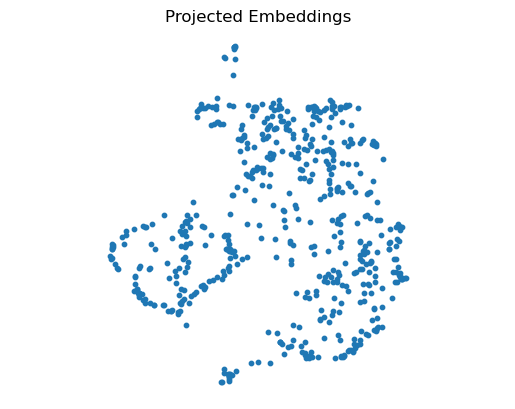

In [17]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

In [18]:
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print((document))
    print('')

professionals and amateurs not in the pro - am are permitted to practice chipping and putting on course prior to the first pro - am starting time. full shots or bunker shots on course are not permitted. on pro - am days at tournaments played after the masters tournament until the conclusion of the fedexcup playoffs, professionals and amateurs not in the pro - am are permitted to practice all shots on course prior to the first pro - am starting time. any practice taking place prior to the pro - am must not interfere with the pace of play of the pro - am and players shall not endanger persons preparing the golf course for the pro - am. on practice days, after 8 : 30 a. m. all play must begin from the first tee unless expressly approved by a member of the rules committee. this rule does not apply to tournaments using the 9 & 9 pro - am format.

the conclusion of the fedexcup playoffs, professionals and amateurs not in the pro - am are permitted to practice all shots on course prior to the

In [19]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


(8.772855043411255, 17.4933660030365, 2.6122208714485167, 12.540333878993987)

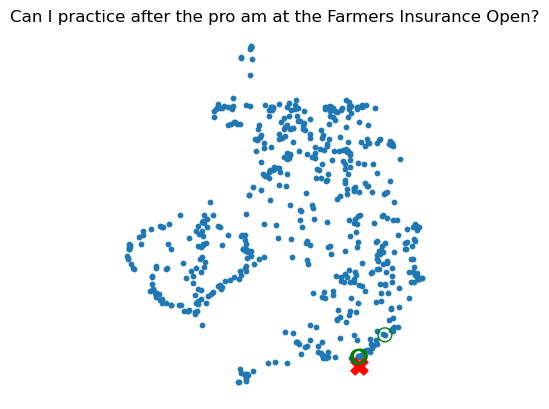

In [20]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)#, color='blue')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [25]:
query = "What has Michael Jordan done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print((document))
    print('')

....... 87 pga tour player of the year / jack nicklaus award............................................... 87 pga tour rookie of the year / arnold palmer award............................................. 87 pga tour courage award.................................................................................................. 87

andy levinson, senior vice president, tournament administration, at pga tour headquarters.

with a panel composed of the current chairman of the player advisory council, one of the tour ’ s independent directors, the president of the usga, the president of the pga of america, the current president of the pga tour tournaments association and past winners of the payne stewart award.

president, tournament administration, at pga tour headquarters.

88since he actually played 12 shots better than the field did at the tournament. any player with an incomplete round is ineligible to win the vardon trophy. pga tour lifetime achievement award this award is given to 

In [26]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


(8.772855043411255, 17.4933660030365, 2.6122208714485167, 12.540333878993987)

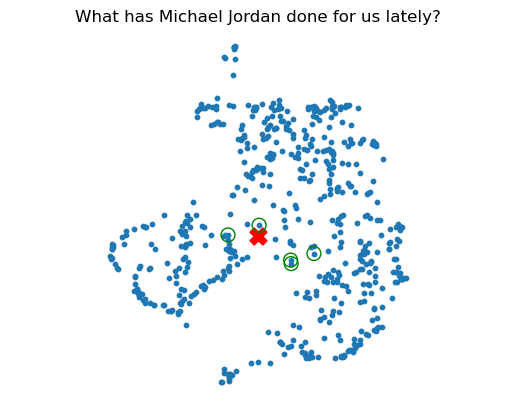

In [27]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)#, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

## Query Expension

In [29]:
original_query = "I play out of the 126-150 category. Will I get into the Cognizant Classic?"
hypothetical_answer = query_expansion(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print((joint_query))

I play out of the 126-150 category. Will I get into the Cognizant Classic?  <question>
I play out of the 126-150 category. Will I get into the Cognizant Classic? Provide which details in the context you are using to generate your response.  
</question>

Based on the PGA TOUR tournament regulations, players are prioritized for tournament entry based on their FedExCup points standing. Since you indicate playing out of the 126-150 category, that suggests you are ranked between 126-150 in FedExCup points. For a tournament like the Cognizant Classic, the field is generally comprised of the top 125 players in FedExCup points, as well as sponsor exemptions. Therefore, being ranked 126-150 in points means you would currently be below the cutoff for automatic entry into the Cognizant Classic field. However, you may still have a chance to play as a sponsor exemption pick. I would recommend contacting the tournament directly to inquire about the possibility of a sponsor exemption spot.


In [31]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print((doc))
    print('')

• top 50 players from the prior year ’ s fedexcup playoffs & eligibility points list through the playoffs • top 10 available pga tour members, not otherwise exempt, from the current season ’ s fedexcup playoffs & eligibility points list through the us open • top 5 available players, not otherwise exempt, who accumulate the most fedexcup points in the “ swing ” of full - field events prior to the event ( myrtle beach classic, charles schwab challenge, rbc canadian open ) • official tournament winners of full point events in the current season, not otherwise exempt • pga tour members, not otherwise exempt, who are within the top 30 of the official world golf ranking as of the monday of tournament week ( monday, june 17, 2024 ) • four sponsor exemptions restricted to pga tour members • one exemption designated for the defending champion, if needed • exempt pga tour members ( “ q - school category and above ” as defined in article iii, section a1a ( 1 ) - ( 11 ) and ( 18 ) and section a1b 

In [32]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


(8.772855043411255, 17.4933660030365, 2.6122208714485167, 12.540333878993987)

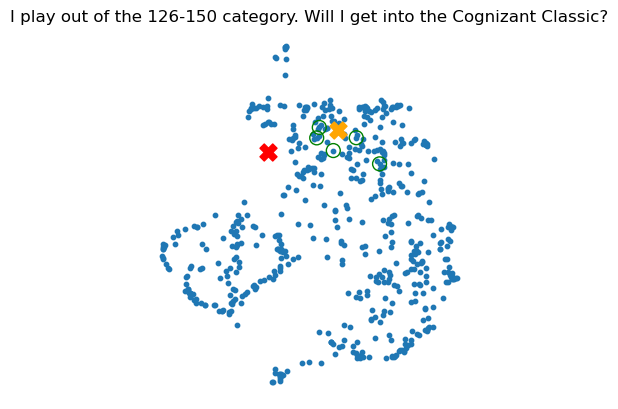

In [33]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)#, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

In [34]:
original_query = "I play out of the 126-150 category. Will I get into the Cognizant Classic?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

 Here are 5 suggested related questions about the PGA TOUR player handbook and tournament regulations for your original question:

1. What are the eligibility criteria for the 126-150 category at the Cognizant Classic?

2. How many spots are available for the 126-150 category at the Cognizant Classic? 

3. When will I find out if I got into the Cognizant Classic from the 126-150 category?

4. What happens if more than the allotted number of players from the 126-150 category want to play in the Cognizant Classic? 

5. If I don't get into the Cognizant Classic from the 126-150 category, can I try to qualify another way?

To generate these questions, I focused on the details in your original question about playing out of the 126-150 category and trying to get into the Cognizant Classic tournament. My suggested questions aim to provide more information about the eligibility, selection process, schedule, and alternatives for that specific category at that specific event.


In [35]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print((doc))
        print('')
    print('-'*100)

Query: I play out of the 126-150 category. Will I get into the Cognizant Classic?

Results:
note : la quinta cc and nicklaus tournament course at pga west also used. note : the winner of a pga tour cosponsored or approved tournament held in the imme - diately preceding week, or any professional who finishes among the top 10 finishers or tied for 10th, not otherwise exempt, excluding non - members and special temporary members in the kentucky championship and barracuda championship ( see article iii, section a - 1 ( g ) of tournament regulations ), may commit to an on - site pga tour media official for the next open pga tour cosponsored tournament, within one - half hour after the conclusion of play.

• pga tour members eligible to participate in tournaments to the extent provided in sec - tions a - 1c ( top 125 fedexcup ), and a - 1d ( top 125 - nonmembers ) of article iii. • players with 50 or more career cuts made in official money pga tour cosponsored or approved tournaments and who

In [36]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


In [37]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 70/70 [01:06<00:00,  1.05it/s]


(8.772855043411255, 17.4933660030365, 2.6122208714485167, 12.540333878993987)

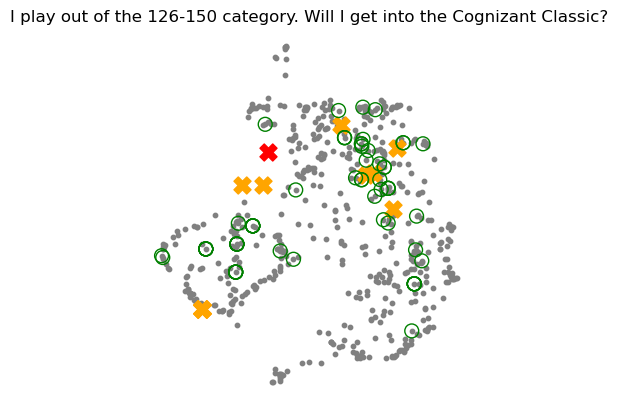

In [38]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

# Cross encoder Ranking

In [39]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [40]:
#query = "What has been the investment in research and development?"
query = "tell me the exemption rule when I have won five chamionship"

results = chroma_collection.query(query_texts=query, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]


In [41]:
pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)
print("Scores:")
for score in scores:
    print(score)

Scores:
-2.135962
-0.75662637
-7.3967505
-9.213014
-7.214642
-7.741056
-9.580339
-7.7950096
-1.5530268
-9.085095


In [42]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o+1)

New Ordering:
2
9
1
5
3
6
8
10
4
7


In [49]:
retrieved_documents[4]

'classic ) may elect to use this special one - time, one - season exemption for the next season, subject to the conditions set forth below and provided that the member may be eligible for both seasons of this exemption only if he : ( i ) is among the top 25 on the official pga tour career money list at the time of his first season of such exemption, and remains among the top 50 on the official pga tour career money list at the end of the fedexcup season preceding the second season of such exemption ; or ( ii ) accepts the first such exemption as one of the top 50 members on the official pga tour career money list as provided in ( a ) above, and then is among the top 25 on the official pga tour career money list as of the end of the fedexcup season preceding the second season for which he requests such exemption. ( d ) members intending to use the eligibility in this subsection in a season must so inform the pga tour no later than 10 days after the conclusion of the pga'